# Sentiment Analysis in Python

#### This notebook references Rob Mulla's [Youtube Tutorial](https://www.youtube.com/watch?v=QpzMWQvxXWk) and uses various techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner)
2. Roberta Pretrained Model
3. Huggingface Pipeline

## 0. Reading Data 

In [1]:
# Dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [6]:
# Read data
df = pd.read_csv('../data/Reviews.csv')
print(df.shape)

df_sample = df.head(10000)
print(df_sample.shape)

(568454, 10)
(10000, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Data Exploration

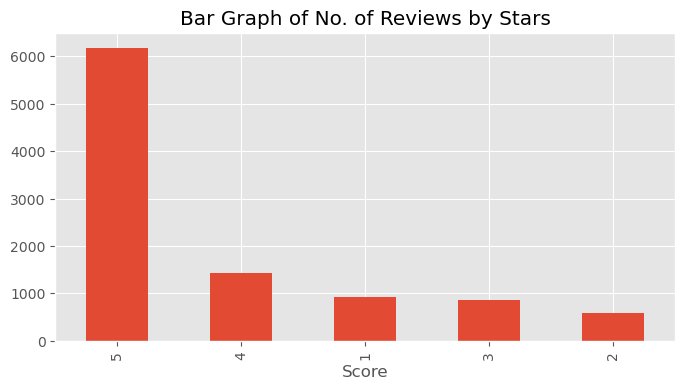

In [12]:
ax = df_sample['Score'].value_counts() \
    .plot(kind='bar', 
          title='Bar Graph of No. of Reviews by Stars',
          figsize=(8,4))
ax.set_xlabel('Score')
plt.show()

We observe a imbalance in the dataset, skewed towards positive ratings (score=5).

### Basic NLTK

In [14]:
# Example of review

example = df_sample['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [20]:
# Tokenize the example

tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [24]:
# Part of speech values for each token

tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

See: https://www.learntek.org/blog/categorizing-pos-tagging-nltk-python/ for definitions of tags.

In [31]:
# Group into chunks of texts / entities

entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 1. VADER Sentiment Scoring

Use of NLTK's `SentimentIntensityAnalyzer` to get the negative/neutral/positive scores of texts.

* "Bag of words" approach:
    1. Remove stop words
    2. Score each word (neg/neu/pos) and combine to get total score
* Limitations: Does not account for relationships between words

In [36]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [41]:
print(sia.polarity_scores('I am happy!'))
print(sia.polarity_scores('Sadly, I am doing quite good...'))
print(sia.polarity_scores(example))

{'neg': 0.0, 'neu': 0.2, 'pos': 0.8, 'compound': 0.6114}
{'neg': 0.412, 'neu': 0.588, 'pos': 0.0, 'compound': -0.4215}
{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}


In [50]:
# Run polarity score on dataset

result = {}
for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    text = row['Text']
    my_id = row['Id']
    result[my_id] = sia.polarity_scores(text)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [55]:
vaders = pd.DataFrame(result).T
vaders = vaders.reset_index().rename(columns={'index' : 'Id'})
vaders = vaders.merge(df_sample, how='left')

In [57]:
# We get a sentiment score
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Plot Vaders

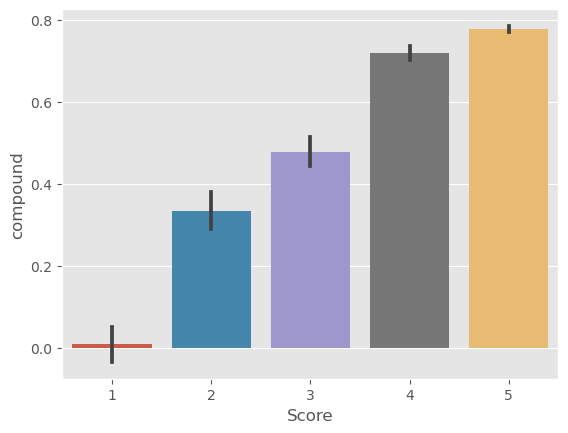

In [60]:
sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title("Compound Score by Amazon Reviewer Score")
plt.show()

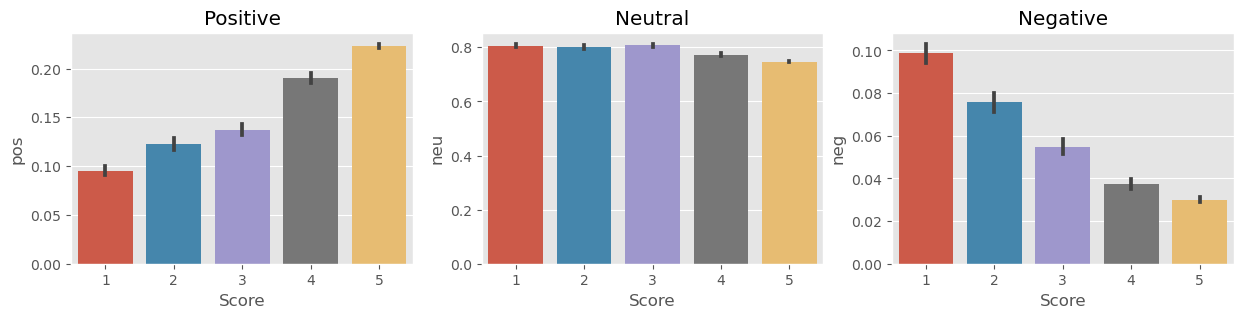

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(15,3))

sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

## Step 3. Roberta Pretrained Model

* Model trained on large corpus of data
* Transformer model accounts for words and context related to other words

In [66]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [67]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [70]:
# VADER Comparison
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [79]:
# Run using Roberta Model
# pt for pytorch
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)

scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}

scores_dict

{'roberta_neg': 0.97635514,
 'roberta_neu': 0.020687463,
 'roberta_pos': 0.0029573694}

In [80]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)

    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict


In [93]:
result = {}
for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)):

    try: 
        text = row['Text']
        my_id = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for k, v in vader_result.items():
            vader_result_rename[f"vader_{k}"] = v


        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}

        result[my_id] = both
    
    except RuntimeError:
        print(f'Skipped {my_id}')


  0%|          | 0/10000 [00:00<?, ?it/s]

Skipped 83
Skipped 187
Skipped 529
Skipped 540
Skipped 746
Skipped 863
Skipped 1053
Skipped 1070
Skipped 1156
Skipped 1321
Skipped 1375
Skipped 1498
Skipped 1575
Skipped 1796
Skipped 1826
Skipped 2169
Skipped 2248
Skipped 2476
Skipped 2492
Skipped 2584
Skipped 2610
Skipped 2897
Skipped 2898
Skipped 2902
Skipped 2928
Skipped 2942
Skipped 2944
Skipped 2947
Skipped 2948
Skipped 3022
Skipped 3023
Skipped 3025
Skipped 3306
Skipped 3788
Skipped 3969
Skipped 4107
Skipped 4110
Skipped 4307
Skipped 4316
Skipped 4408
Skipped 4483
Skipped 4512
Skipped 4553
Skipped 4583
Skipped 5040
Skipped 5182
Skipped 5192
Skipped 5365
Skipped 5442
Skipped 5709
Skipped 5998
Skipped 6003
Skipped 6007
Skipped 6106
Skipped 6234
Skipped 6558
Skipped 6651
Skipped 6798
Skipped 6838
Skipped 6850
Skipped 6886
Skipped 6905
Skipped 6955
Skipped 7077
Skipped 7088
Skipped 7201
Skipped 7604
Skipped 7608
Skipped 7671
Skipped 7701
Skipped 7810
Skipped 7907
Skipped 8077
Skipped 8131
Skipped 8266
Skipped 8740
Skipped 8757
Skippe

In [94]:
results_df = pd.DataFrame(result).T
results_df = results_df.reset_index().rename(columns={'index' : 'Id'})
results_df = results_df.merge(df_sample, how='left')

In [97]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098068,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Step 3. Compare Scores btw Models

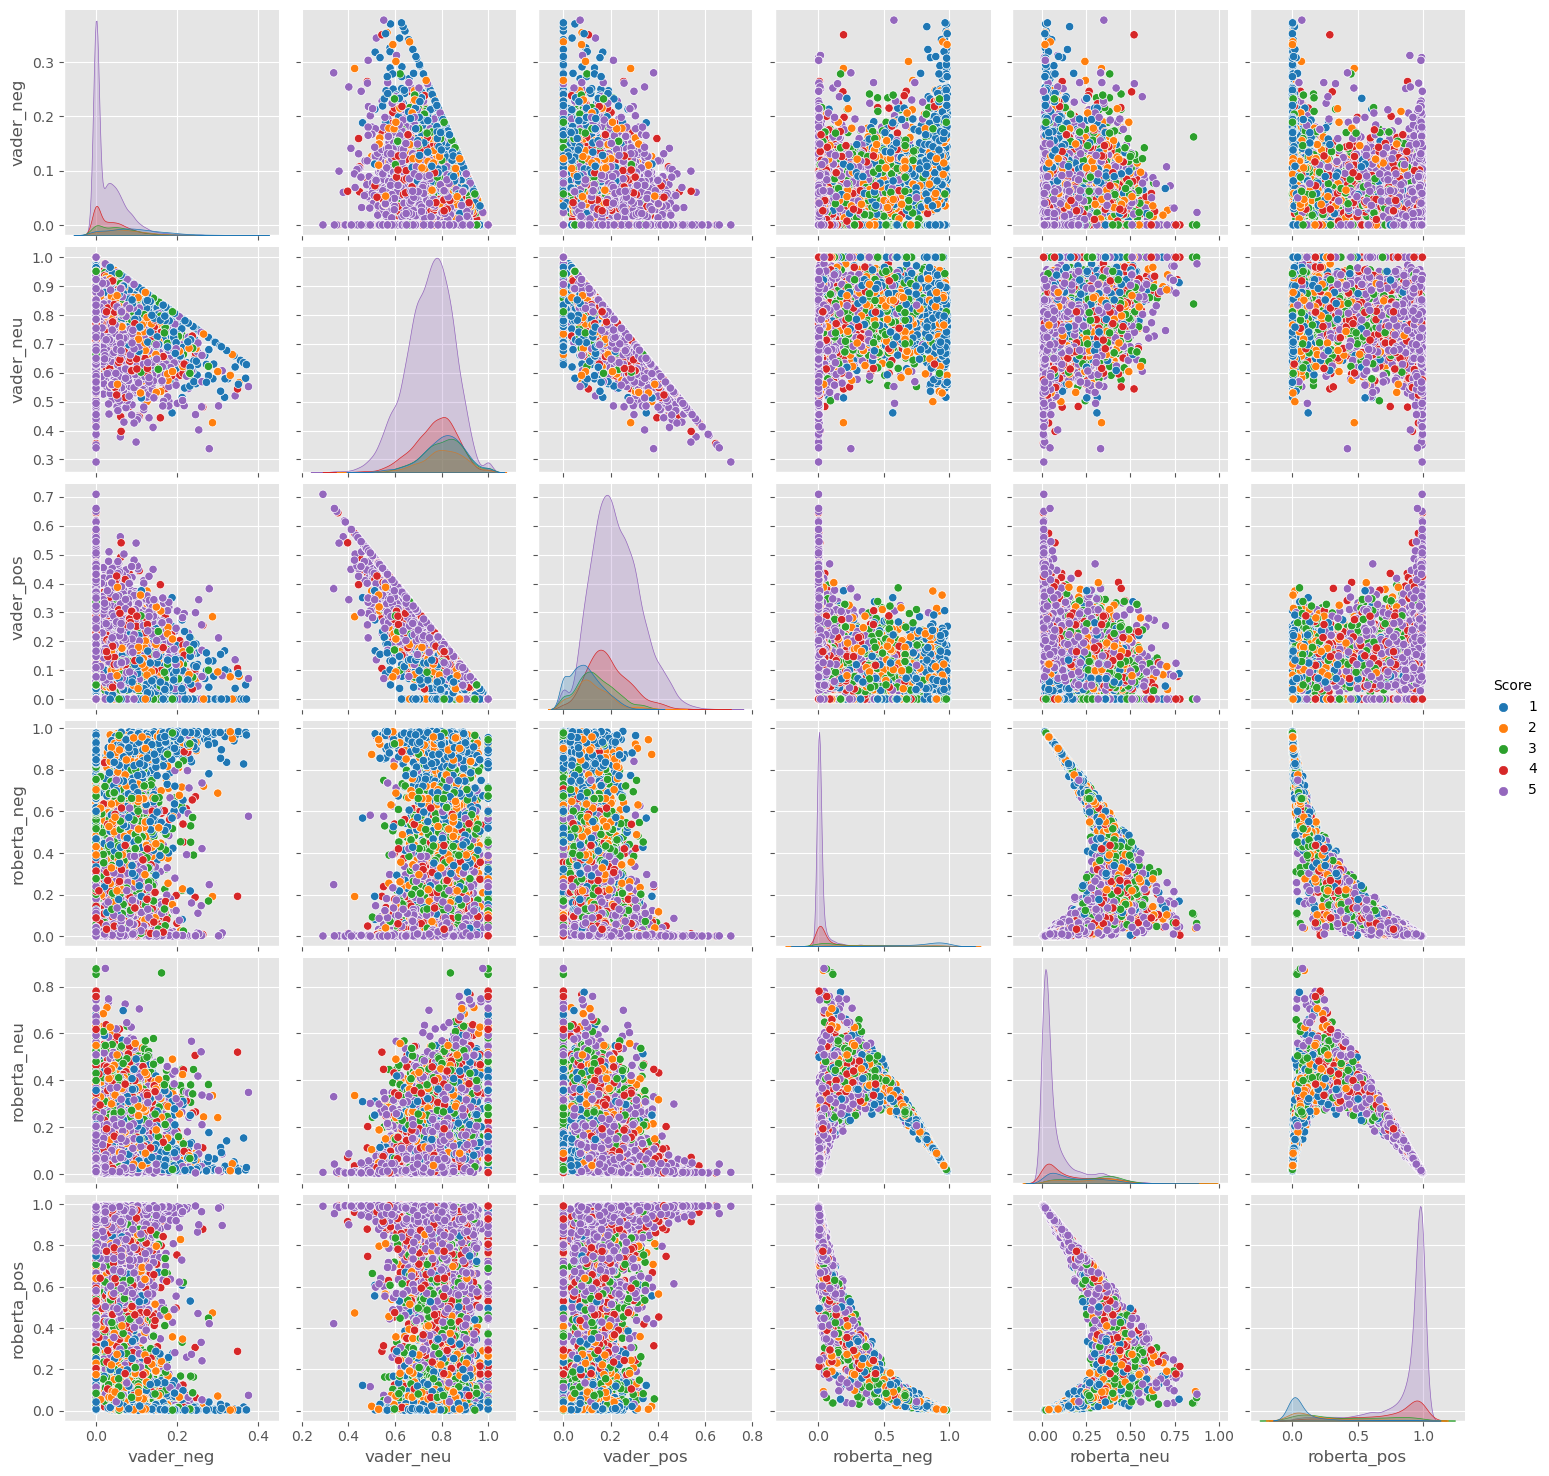

In [99]:
sns.pairplot(data=results_df, 
             vars=['vader_neg', 'vader_neu',	'vader_pos', 'roberta_neg',	'roberta_neu', 'roberta_pos'],
             hue='Score',
             palette='tab10')
plt.show()

## Step 4: Review Examples

* We're interested in 'Positive' 1-Star and 'Negative' 5-Star Scores

In [106]:
# positive prediction, 1 star review

results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'This flavor is horrible.  There are many other flavors much better.  Hawaiian Hazelnut is great!  Breakfast in Bed is AWesome!'

In [108]:
# negative prediction, 5 star review

results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'They have a bad taste,i finish giving them away because my son started to cry everytime i tried to give these.I prefer Beech nut or Gerber.Yuck!'

## Transformers Pipeline

In [112]:
# from transformers import pipeline

# sentiment_pipeline = pipeline("sentiment-analysis")
# sentiment_pipeline('This flavor is horrible.  There are many other flavors much better.  Hawaiian Hazelnut is great!  Breakfast in Bed is AWesome!')
